In [13]:
# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
import joblib

## Preprocessing

In [2]:
# Read the CSV file
df = pd.read_csv("resources/updated_pollution_dataset.csv")

# Review the DataFrame
df.head(5)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [3]:
# Check the number of rows
num_entries = len(df)
print(f"Number of entries: {num_entries}")

Number of entries: 5000


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64


In [5]:
# Check value counts for each class
print(df['Air Quality'].value_counts())

Air Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64


In [6]:
# Split the preprocessed data into features and target arrays
X = df.drop(columns='Air Quality').values # Remove target variable from features
y = pd.get_dummies(df['Air Quality'], prefix='AirQuality').values  # One-hot encode the target variable

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Scale Features

In [8]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Check and normalize skewness

In [9]:
# Find all columns with numerical data types
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [10]:
# List skew values for each feature, values over 1 or under -1 are skewed
skewness_values = df[numerical_cols].skew()
skewness_values

Temperature                      0.752187
Humidity                         0.280528
PM2.5                            2.890910
PM10                             2.534815
NO2                              0.638783
SO2                              1.166772
CO                               0.879068
Proximity_to_Industrial_Areas    0.469752
Population_Density               0.204231
dtype: float64

In [11]:
# Use quartile transformer to normalize the data for skewed features
qt = QuantileTransformer(output_distribution='normal')
df[['PM2.5', 'PM10', 'SO2']] = qt.fit_transform(df[['PM2.5', 'PM10', 'SO2']])

In [12]:
# Confirm skewed features were fixed
skewness_values = df[numerical_cols].skew()
skewness_values

Temperature                      0.752187
Humidity                         0.280528
PM2.5                           -0.369815
PM10                            -0.008718
NO2                              0.638783
SO2                              0.000201
CO                               0.879068
Proximity_to_Industrial_Areas    0.469752
Population_Density               0.204231
dtype: float64

## Random Forest Model

In [63]:
# Convert one-hot encoded y_train and y_test back to categorical
y_train_categorical = np.argmax(y_train, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

In [64]:
# Create a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [65]:
# Fit the model
rf_model.fit(X_train_scaled, y_train_categorical)

RandomForestClassifier(random_state=42)

In [66]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

In [67]:
# Print classification report
print(classification_report(y_test_categorical, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       508
           1       0.92      0.86      0.89       121
           2       0.95      0.96      0.95       376
           3       0.88      0.90      0.89       245

    accuracy                           0.95      1250
   macro avg       0.94      0.93      0.93      1250
weighted avg       0.95      0.95      0.95      1250



In [68]:
# Print confusion matrix
print(confusion_matrix(y_test_categorical, y_pred))

[[507   0   1   0]
 [  0 104   1  16]
 [  2   0 360  14]
 [  0   9  16 220]]


## Random Forest Model Analysis
#### This model performed very well overall with an accuracy score of 0.95. The model also yielded perfect precision and recall in the "Good" class and above 0.85 for those metrics in all other classes.

#### The confusion matrix also provides evidence of this model's predictive ability. The class with the least accuracy was the "Hazardous" class, though there were a greater number of false positives than false negatives. This is preferred as it is more dangerous to public health to predict that the air quality is better than it actually is.

## Random Forest Model Confusion Matrix Breakdown:

### Class 0 (Good): 
507 instances were correctly predicted as Class 0. No false positives and 1 false negative were predicted.

### Class 1 (Moderate): 
104 instances were correctly predicted as Class 1. No false positives and 1 false negative were predicted.

### Class 2 (Poor): 
360 instances were correctly predicted as Class 2. 1 false positive and 2 false negatives were predicted.

### Class 3 (Hazardous): 
220 instances were correctly predicted as Class 3. 16 false positives and 9 false negatives were predicted.

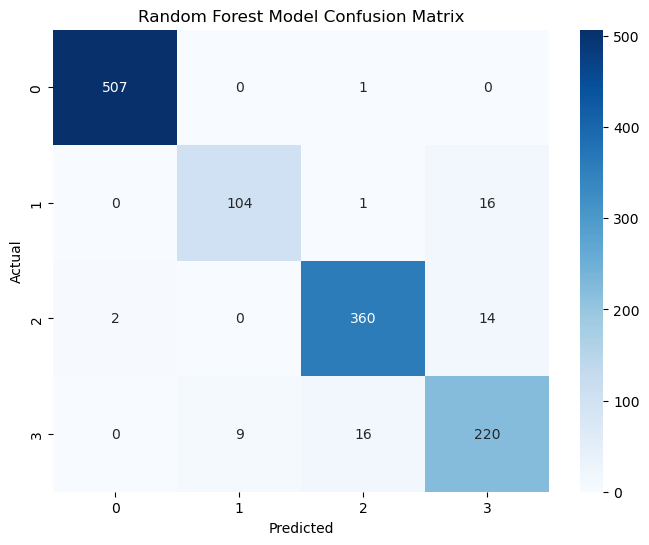

In [69]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_categorical, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Model Confusion Matrix')
plt.show()

## k-Nearest Neighbors Model

In [70]:
# Convert to single-label format since our target variable is one-hot encoded
y_test_single = np.argmax(y_test)
y_pred_single = np.argmax(y_pred)

In [71]:
# Specify the number of clusters and create the model
k = 4
knn_model = KNeighborsClassifier(n_neighbors=k)

In [72]:
# Fit the model
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=4)

In [73]:
# Make predictions
y_pred = knn_model.predict(X_test_scaled)

In [74]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       508
           1       0.95      0.68      0.79       121
           2       0.92      0.92      0.92       376
           3       0.85      0.71      0.78       245

   micro avg       0.94      0.89      0.91      1250
   macro avg       0.93      0.83      0.87      1250
weighted avg       0.94      0.89      0.91      1250
 samples avg       0.89      0.89      0.89      1250



C:\Users\hebir\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
# Convert y_test and y_pred to categorical for the confusion matrix
y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

In [76]:
# Create and print the confusion matrix
cm = confusion_matrix(y_test_single, y_pred_single)
cm

array([[508,   0,   0,   0],
       [ 15,  82,   0,  24],
       [ 23,   0, 346,   7],
       [ 37,   4,  29, 175]], dtype=int64)

## k-Nearest Neighbors Model Analysis
#### This model also yielded a high accuracy score of 0.94. Similarily to the Random Forest Model, precision and recall are best for the "Good" class. However, this model shows a drop in recall for both the "Moderate" and "Hazardous" classes, indicating that the model may be identifying less true positives there. This may be problematic as false negatives in those classes could lead to public misinformation on air quality. 

#### The confusion matrix shows that the model yielded a moderate number of false negatives for all classes except "Good". This is not ideal for a model used for this purpose as false negatives will be costly in a real world scenario. The visualization shows good separation of individual clusters.

## k-Nearest Neighbors Model Confusion Matrix Breakdown:

### Class 0 (Good): 
508 instances were correctly predicted as Class 0. 0 false positives and 0 false negatives were predicted.

### Class 1 (Moderate): 
82 instances were correctly predicted as Class 1. 15 false positives and 15 false negatives were predicted.

### Class 2 (Poor): 
346 instances were correctly predicted as Class 2. 0 false positives and 23 false negatives were predicted.

### Class 3 (Hazardous): 
175 instances were correctly predicted as Class 3. 37 false positives and 29 false negatives were predicted.

In [77]:
# Create a DataFrame for visualization
cm_df = pd.DataFrame(cm, index=["Good", "Moderate", "Poor", "Hazardous"], columns=["Good", "Moderate", "Poor", "Hazardous"])

In [78]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

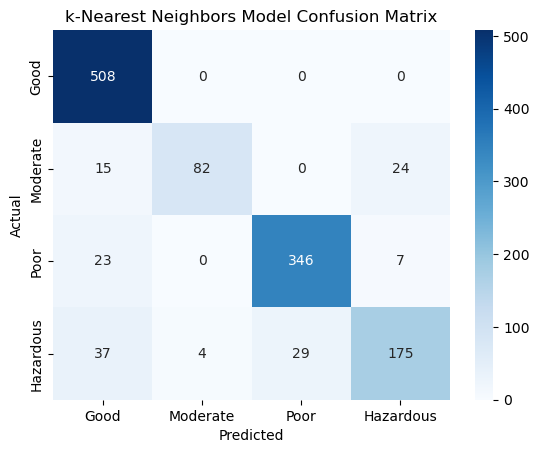

In [79]:
# Create a heatmap
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)

# Add labels and title
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('k-Nearest Neighbors Model Confusion Matrix')

plt.show()

In [80]:
# Fit the KNN model
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [81]:
# Get the cluster labels
labels = kmeans.labels_

In [82]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

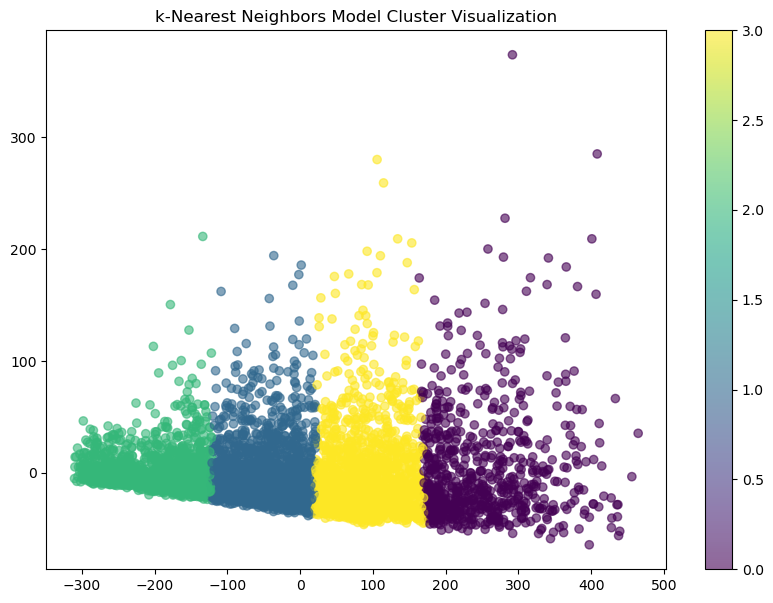

In [83]:
# Plot clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('k-Nearest Neighbors Model Cluster Visualization')
plt.show()

## Neural Network Model

In [34]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
# Create the model
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', 
                          input_shape=(X_train_scaled.shape[1],),
                          kernel_regularizer=regularizers.l2(0.01)),  # Add L2 regularization to fix overfitting
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(4, activation='softmax')  # softmax to accommodate 4 classes
])

C:\Users\hebir\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Random seeds were set to ensure random numbers generated will be the same for both NumPy and TensorFlow so results can be replicated.

### A simple 3 layer Sequential model was created with L2 regularization to account for overfitting and softmax activation to accommodate our 4 classes.

In [49]:
# Compile the model
nn_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [50]:
# Fit the model and capture the training history
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5572 - loss: 1.7306 - val_accuracy: 0.8373 - val_loss: 0.9810
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8761 - loss: 0.8528 - val_accuracy: 0.8800 - val_loss: 0.6606
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9043 - loss: 0.5946 - val_accuracy: 0.8947 - val_loss: 0.5064
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9176 - loss: 0.4635 - val_accuracy: 0.9040 - val_loss: 0.4194
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9297 - loss: 0.3897 - val_accuracy: 0.9120 - val_loss: 0.3673
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.3445 - val_accuracy: 0.9173 - val_loss: 0.3342
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9386 - loss: 0.3152 - val_accuracy: 0.9227 - val_loss: 0.3130
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9384 - loss: 0.2957 - val_accuracy: 0.9253 - v

In [51]:
# Evaluate the model
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {accuracy:.2f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.1886 
Test accuracy: 0.94


In [52]:
# Make predictions
y_pred = nn_model.predict(X_test_scaled)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [53]:
# Convert predictions from probabilities to class labels
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

In [54]:
# Convert one-hot encoded y_test to class labels
y_test_classes = tf.argmax(y_test, axis=1).numpy()  # Use y_test directly

In [55]:
# Generate classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       508
           1       0.96      0.79      0.87       121
           2       0.92      0.97      0.95       376
           3       0.87      0.87      0.87       245

    accuracy                           0.94      1250
   macro avg       0.94      0.91      0.92      1250
weighted avg       0.94      0.94      0.94      1250



## Neural Network Model Analysis
#### This model performed very well, with an accuracy score of 0.94 and good precision and recall scores across all classes. The visualizations showing the relationships between training and validation accuracy and loss support the evidence that this is a strong model. 

#### Following a steep inital drop, both training loss and validation loss steadily decrease over epochs, indicating that the model is learning from the training data. The reverse is true for accuracy over epochs, indicating the model's improvement in classifying the training data. 

#### The high accuracy score, consistency across classes in precision and recall, and the information revealed by the loss and accuracy plots make this the model of choice to predict air quality. 

In [56]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

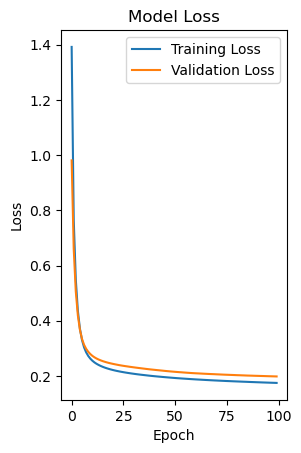

In [57]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(fit_model.history['loss'], label='Training Loss')
plt.plot(fit_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

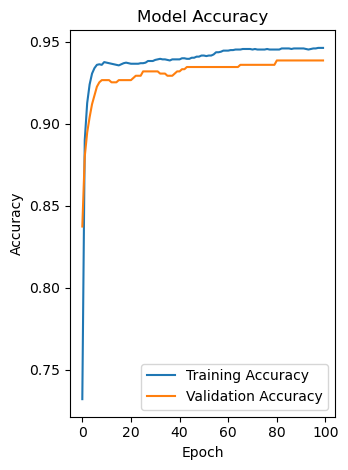

In [58]:
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(fit_model.history['accuracy'], label='Training Accuracy')
plt.plot(fit_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Save the nn model as a .keras file 
nn_model.save('nn_model.keras')

In [ ]:
# Save the scaler as a .pkl file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)